<font size = "5"> **[Diffraction Tools](1_Diffraction_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


#  Analyzing Ring Diffraction Pattern


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Diffraction/D1_Diffraction_Rings.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Diffraction/D1_Diffraction_Rings.ipynb)
    
    

part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content

An introduction into **diffraction_tools** and how to use the functions in this package to 
index ring diffraction pattern of polycrystalline samples.

The scope of this notebook includes calculation and plotting of 
- scattering profiles,
- publication quality figure.
  
An explanation on the physcial background can be found in the *Diffraction* chapter of MSE672-Introduction to TEM


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](../0_pyTEMlib.ipynb), please test and install [pyTEMlib](https://github.com/pycroscopy/pyTEMlib) and other important packages with the code cell below.



## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test whether package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.12.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

print('done')

### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library from diffraction_tools in pyTEMlib.

In [13]:
%matplotlib  widget
import os
import sys
single

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()

# Import microscopt library
sys.path.insert(0, "../../")  # point to the pyTEMlib location
%load_ext autoreload
%autoreload 2
import pyTEMlib
    
# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2025.12.06'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2025.12.1
notebook version:  2025.12.06



## Load Ring-Diffraction Pattern
### First we select the diffraction pattern

Load the **GOLD-NP-DIFF.dm3** file as an example.
  
The dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

In [2]:
# ------Input -------------
load_your_own_data = False
# -------------------------
if 'google.colab' in sys.modules:
        drive.mount("/content/drive")

if load_your_own_data:
    fileWidget = pyTEMlib.file_tools.FileWidget()

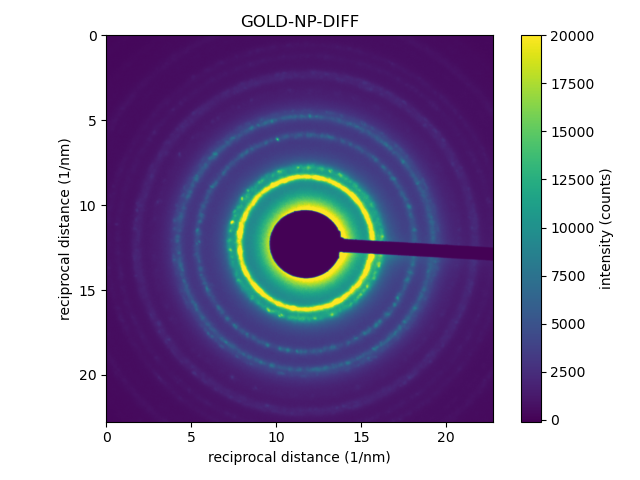

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: divide by zero encountered in log2
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in log2
  return self.func(*new_argspec)


In [3]:
if load_your_own_data:
    datasets = fileWidget.datasets
    main_dataset = fileWidget.selected_dataset
else:  # load example
    datasets = pyTEMlib.file_tools.open_file(os.path.join("../../example_data", "GOLD-NP-DIFF.dm3"))
    main_dataset =  datasets['Channel_000']

view = main_dataset.plot(vmax=20000)

## Finding the center

### Select the center yourself

If there is a beam stop, the center is hard to find, use the selection to get center.
    
Cross correlation and auto correlation are based on a  multiplication in Fourier space. In the case of a an auto-correlation it is the same data while in the cross correlation it is another data (here the transposed (rotated) diffraction pattern)"

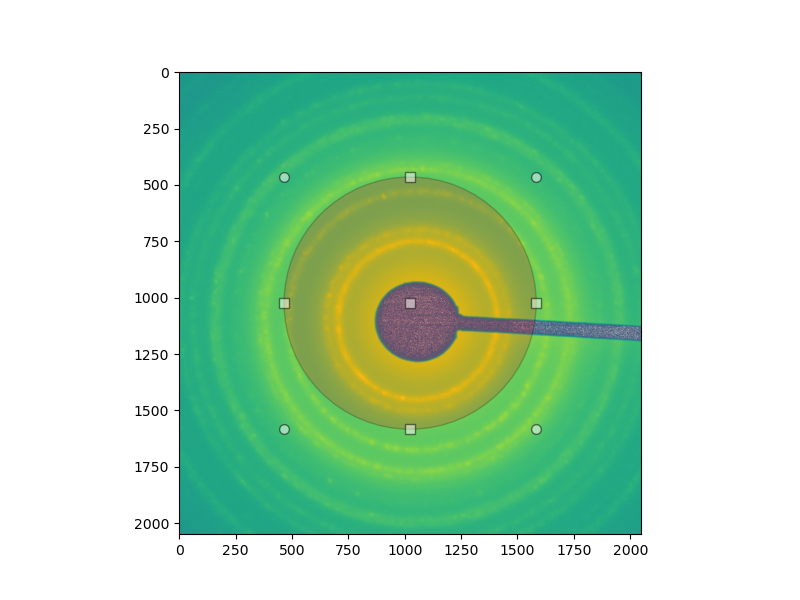

In [4]:

center = np.array(main_dataset.shape)/2

plt.figure(figsize=(8, 6))
plt.imshow(np.log(3.+main_dataset).T, origin = 'upper')
# gca get current axis (plot)
selector = matplotlib.widgets.EllipseSelector(plt.gca(), None,interactive=True )
# selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)

Get center coordinates from selection

In [5]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - main_dataset.shape[0]/2
y_shift = y_center - main_dataset.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center)
print(f'center = {center[0]:.1f}, {center[1]:.1f} [pixels]')


radius = 559 pixels
center = 1059.5, 1099.4 [pixels]


## Ploting Diffraction Pattern in Polar Coordinates",

### The Transformation Routine

We use the polar transformation routine of scipy-image (skimage) **skimage.transform.warp_polar**

If the center is correct a ring in carthesian coordinates is a line in polar coordinates

### Diffraction Profile

A simple sum over all angles gives us then the diffraction profile (intensity profile of diffraction pattern)


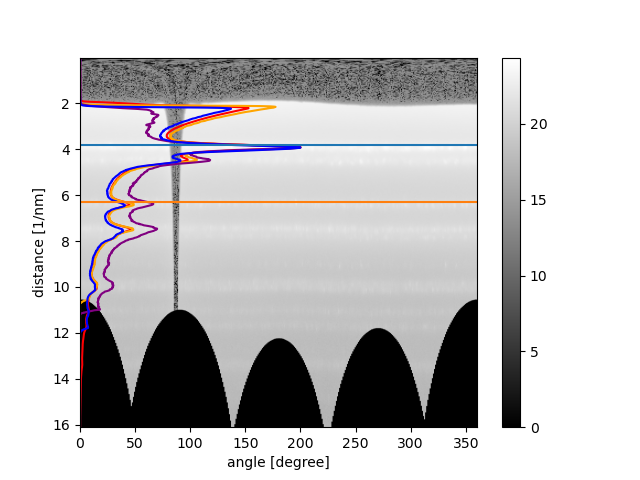

In [6]:
tags = pyTEMlib.diffraction_tools.scattering_profiles(main_dataset, center)

# ###################
# Make some profiles
# ###################
profile_0 = tags['polar_projection'][:,0:10].sum(axis=1)
profile_0 += tags['polar_projection'][:,350:360].sum(axis=1)
profile_180 = tags['polar_projection'][:,190:210].sum(axis=1)
profile_270 = tags['polar_projection'][:,260:280].sum(axis=1)
profile_90 = tags['polar_projection'][:,80:100].sum(axis=1)

# ############### 
# Plot

scale = main_dataset.get_image_dims(return_axis=True)[0].slope
extent = (0, 360, tags['polar_projection'].shape[0]*scale, scale)
log_polar = np.log2(tags['polar_projection']+1e-12)
log_polar -= log_polar.min()
plt.figure()
plt.imshow(log_polar, extent=extent, cmap="gray")
ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(tags['radial_average']/tags['radial_average'].max()*200,
         np.linspace(1,len(tags['radial_average']),len(tags['radial_average']))*scale,
         c='r')
plt.plot(profile_0/profile_0.max()*200,
         np.linspace(1,len(profile_0),len(profile_0))*scale,
         c='orange');
plt.plot(profile_90/profile_90.max()*200,
         np.linspace(1,len(profile_90),len(profile_90))*scale,c='purple');
plt.plot(profile_270/profile_270.max()*200,
         np.linspace(1,len(profile_270),len(profile_270))*scale,c='b');
plt.plot([0,360],[3.8,3.8])
plt.plot([0,360],[6.3,6.3])
plt.colorbar();


## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

[ 0.3434518   0.49609704  0.99219408  1.41196849  2.5186465   4.46487334
  5.10089518  7.30153076  8.56085401 11.384791   12.55507119 13.38189958
 15.26452424]


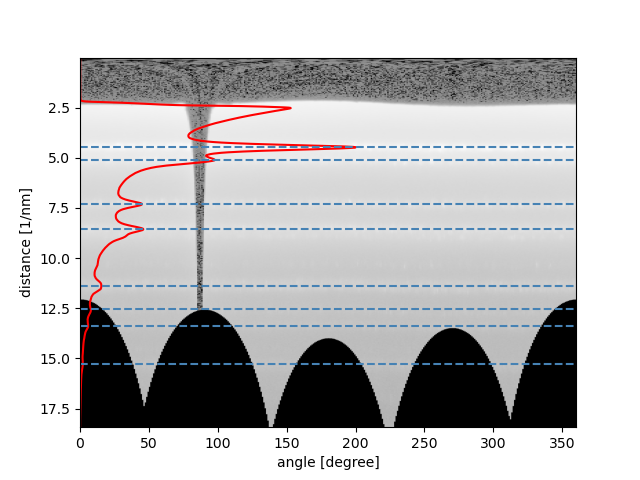

In [7]:
import scipy as sp
import scipy.signal as signal

scale = main_dataset.u.slope*4.28/3.75901247*1.005



# find_Bragg peaks in profile
peaks, g= signal.find_peaks(tags['radial_average'],rel_height =0.7, width=7)  # np.std(second_deriv)*9)

print(peaks*scale)

tags['ring_radii_px'] = peaks


plt.figure()

plt.imshow(log_polar,extent=(0,360,tags['polar_projection'].shape[0]*scale,scale),cmap='gray')

ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(tags['radial_average']/tags['radial_average'].max()*200,
         np.linspace(1,len(tags['radial_average']),len(tags['radial_average']))*scale,
         c='r')
for i in peaks:
    if i*scale > 3.5:
        plt.plot((0,360),(i*scale,i*scale), linestyle='--', c = 'steelblue')

## Calculate Ring Pattern

see [Structure Factors notebook ](CH2_04-Structure_Factors.ipynb) for details.

In [8]:
# -----Input for ring pattern calculation ----
structure = 'gold'
hkl_max = 7
verbose = True
# --------------------------------------------

atoms = pyTEMlib.crystal_tools.structure_by_name(structure)
main_dataset.structures['Structure_000'] = atoms
main_dataset.metadata['experiment']['hkl_max']  = hkl_max

pyTEMlib.diffraction_tools.ring_pattern_calculation(main_dataset, verbose=verbose)


Of the 3374 possible reflection 854 are allowed.
here
Of the 854 allowed reflection 33  have unique distances.


 [hkl]  	 1/d [1/nm] 	 d [nm] 	 F^2 
[1. 1. 1.] 	 4.25 	         0.2355 	 729.11 
[0. 0. 2.] 	 4.90 	         0.2039 	 599.47 
[2. 0. 2.] 	 6.94 	         0.1442 	 333.71 
[1. 1. 3.] 	 8.13 	         0.1230 	 241.36 
[2. 2. 2.] 	 8.49 	         0.1177 	 219.62 
[0. 0. 4.] 	 9.81 	         0.1020 	 158.02 
[3. 3. 1.] 	 10.69 	         0.0936 	 128.30 
[2. 0. 4.] 	 10.97 	         0.0912 	 120.38 
[4. 2. 2.] 	 12.01 	         0.0832 	 95.48 
[3. 3. 3.] 	 12.74 	         0.0785 	 81.88 
[4. 0. 4.] 	 13.87 	         0.0721 	 65.29 
[5. 1. 3.] 	 14.51 	         0.0689 	 57.83 
[4. 4. 2.] 	 14.71 	         0.0680 	 55.65 
[0. 2. 6.] 	 15.51 	         0.0645 	 48.14 
[5. 3. 3.] 	 16.08 	         0.0622 	 43.55 
[2. 2. 6.] 	 16.27 	         0.0615 	 42.17 
[4. 4. 4.] 	 16.99 	         0.0589 	 37.33 
[5. 1. 5.] 	 17.51 	         0.0571 	 34.26 
[0. 4. 6.] 	 17.68 	         0.0566 	 

## Comparison
Comparison between experimental profile and kinematic theory

The grain size will have an influence on the width of the diffraction rings"

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


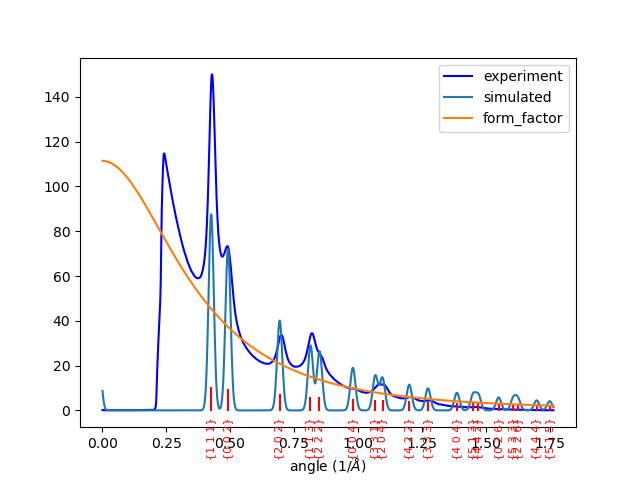

In [9]:
# -------Input of grain size ----
resolution  = .0001 # 1/nm
thickness = 100 # Ang
elements = ['Au', 'C']
# -------------------------------
import scipy

def plot_diffraction_profile(dataset, resolution, thickness, elements=[]):
    tags = dataset.metadata.get('diffraction', {})
    if not tags:
        print("No diffraction metadata found.")
        return  
    unique = tags['Ring_Pattern']['allowed']['g norm']
    family = tags['Ring_Pattern']['allowed']['hkl']
    intensity = np.array(tags['Ring_Pattern']['allowed']['structure_factor'])

    scale = main_dataset.get_image_dims(return_axis=True)[0].slope*1.085*1.0/10*1.01

    width = (1/thickness + resolution) / scale
    
    intensity2 = intensity/intensity.max()*10

    profile = tags['radial_average']
    gauss = scipy.signal.windows.gaussian(len(profile), std=width)
    simulated_profile = np.zeros(len(profile))
    reciprocal_dist = np.linspace(1,len(profile),len(profile))*scale

    x  =[]
    form_factors = np.zeros((len(elements), len(reciprocal_dist)))
    for j, element in enumerate(elements):
        for i, r_dist in enumerate(reciprocal_dist):
            form_factors[j,i] = pyTEMlib.diffraction_tools.form_factor(element, r_dist)
    yAu = form_factors[elements.index('Au')]
    plt.figure()
    plt.plot(reciprocal_dist,profile/profile.max()*150, color='blue', label='experiment');
    for j in range(len(unique)-1):
        if unique[j] < len(profile)*scale:
            # plot lines
            
            plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
            # plot indices
            index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}' # pretty index string
            plt.text(unique[j],-3, index, horizontalalignment='center',
                verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'red')
            
            # place Gaussian with appropriate width in profile
            g = np.roll(gauss,int(-len(profile)/2+unique[j]/scale))* intensity2[j]*np.array(yAu)*1.3#rec_dist**2*10
            simulated_profile = simulated_profile + g
    plt.plot(np.linspace(1,len(profile),len(profile))*scale,simulated_profile, label='simulated');
    plt.plot(reciprocal_dist,np.array(yAu)**2, label='form_factor')
    plt.xlabel(r'angle (1/$\AA$)')
    plt.legend()
#plt.ylim(-35,210);

# pyTEMlib.diffraction_tools.
plot_diffraction_profile(main_dataset, resolution, thickness, elements)

## Publication Quality Output

Now we have all the ingredients to make a publication quality plot of the data.

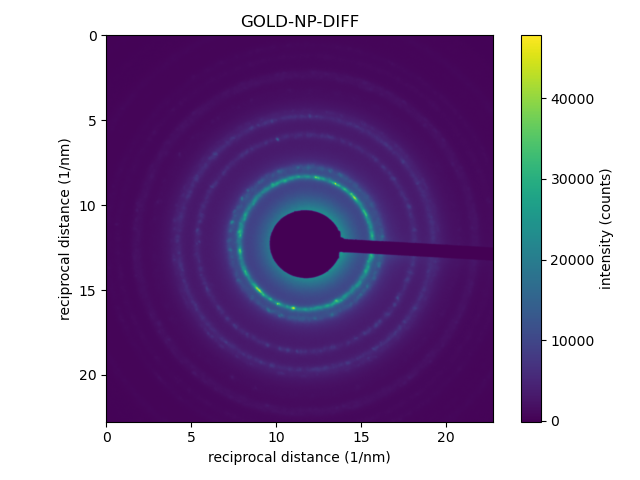

In [10]:
# pyTEMlib.diffraction_tools.
import sidpy
def set_center(main_dataset, center, scale=scale):
    if isinstance(scale, float):
        scale = (scale, scale)
    x_axis = np.linspace(0, main_dataset.shape[0]-1, main_dataset.shape[0])-center[1]
    x_axis *= scale[0]
    y_axis = np.linspace(0, main_dataset.shape[1]-1, main_dataset.shape[1])-center[0]
    y_axis *= -scale[1]
    x = sidpy.Dimension(name='u', values=x_axis)
    
    main_dataset.set_dimension(0, sidpy.Dimension(name='u', values=x_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))
    main_dataset.set_dimension(1, sidpy.Dimension(name='v', values=y_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))

v =main_dataset.plot()


C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


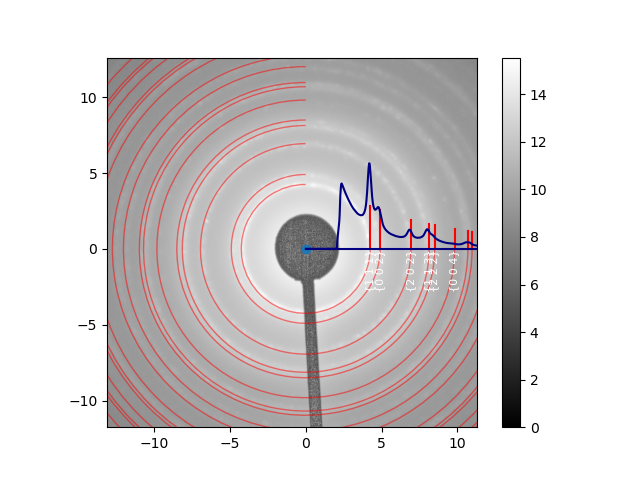

In [11]:
scale  = main_dataset.get_image_dims(return_axis=True)[0].slope

pyTEMlib.diffraction_tools.set_center(main_dataset, center, scale=scale*1.07)
v = pyTEMlib.diffraction_tools.plot_ring_pattern(main_dataset.metadata['diffraction'], main_dataset)

In [ ]:
plt.close('all')

### What does the above figure convey?
* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?

### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattce parameter better than 1% if we use high scattering angles!

## Logging the results

In [12]:
main_dataset.metadata['diffraction']['analysis'] = 'Indexing_Diffraction_Rings'
main_dataset.metadata['diffraction']['scale'] = scale
main_dataset.metadata['diffraction'].keys()

dict_keys(['center', 'polar_projection', 'radial_average', 'Ring_Pattern', 'label_color', 'profile color', 'ring color', 'label_size', 'profile height', 'plot_scalebar', 'analysis', 'scale'])

In [ ]:
h5_group = pyTEMlib.file_tools.save_dataset(datasets, filename='Gold_SAED.hf5')
h5_group.file.close()

## Conclusion

We only need the scatterng factors to calculate the ring pattern.

A comparison between simulation and experiment can be very precise.

Normally one would do a fit of the most prominent peaks to establish the scale.